In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

/home/stephen/anaconda3/envs/deepmr/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
np.random.seed(42)

In [5]:
sequence_length = 100
includes_confounder = False

data_dir = '../dat/sim'
test_data_fpath = os.path.join(data_dir, 'test_labels.csv')
raw_simulation_data_fpath = os.path.join(data_dir, 'test_sequences.simdata')

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"
confounder_motif = "SOX2_1" if includes_confounder else None

In [6]:
torch.set_grad_enabled(False)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [7]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

test_df.head()

,sequences,labels_exp,labels_out,has_exposure,has_outcome,has_both,has_confounder
0,ATCCTGTATACCGTGTCTCACCAGATGGTACGTGTTGCATTTTCTT...,0,0,0,1,0,0
1,GGAGCTCTAGTGGCATTGGTGATAAGCACGCTGAGGAACGAGTAAG...,108,0,1,0,0,0
2,AGTAGAGTGAACCGGAGTACCAGATGTTAAGACGTCATCCTGGTCT...,1,5,0,1,0,0
3,AGAGTATCAAGCAACTACGATAACAATGCGGCATCCCTATATTGCT...,80,96,0,1,0,0
4,GCGAGATTAGGCGTGGATGTAACGCCGATACTTGGAATTGTCCTGA...,97,118,1,1,1,0


In [8]:
both_motifs_df = test_df[(test_df['has_both'] == 1)]
exposure_motif_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 0)]
outcome_motif_df = test_df[(test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 1)]
neither_motif_df = test_df[
    (test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 0)
]

In [9]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2499, 2514, 2460, 2527)

In [45]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform,
)
exposure_motif_dataset = IterablePandasDataset(
    exposure_motif_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform
)

In [46]:
def mutate(seqs):
    preds = {}
    all_muts = []
    for seq in tqdm(seqs):
        muts = generate_wt_mut_batches(seq, seq.shape[0] * seq.shape[1]).squeeze()
        muts = muts.transpose(0, 1, 2)
        all_muts.append(muts)
        
    return np.array(all_muts)

In [47]:
both_motifs_sample_seqs = [x for x, y in both_motifs_dataset]

In [48]:
exposure_motif_sample_seqs = [x for x, y in exposure_motif_dataset]

In [49]:
sample_seqs = np.array([seq for seq, label in both_motifs_dataset])
sample_labels = np.array([label for _, label in both_motifs_dataset])
sample_muts = mutate(sample_seqs)

In [50]:
motifs = synthetic.LoadedEncodeMotifs(
    simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001
)
exposure_pwm = motifs.loadedMotifs[exposure_motif].getRows()
outcome_pwm = motifs.loadedMotifs[outcome_motif].getRows()
confounder_pwm = None if confounder_motif is None else motifs.loadedMotifs[confounder_motif].getRows()
confounder_pwm

In [51]:
adjusted_labels_ism = []
for i, muts in enumerate(tqdm(sample_muts)):
    adjusted_labels_ = simulate_oracle_predictions(
        [one_hot_decode(mut) for mut in muts],
        exposure_pwm,
        outcome_pwm,
        confounder_pwm=confounder_pwm,
    )
    adjusted_labels_ism.append(adjusted_labels_)

In [52]:
np.array(adjusted_labels_ism).shape

(2499, 6, 400)

In [53]:
adjusted_labels_ism_no_conf = []
if includes_confounder:
    for i, muts in enumerate(tqdm(sample_muts)):
        adjusted_labels_ = simulate_oracle_predictions(
            [one_hot_decode(mut) for mut in muts],
            exposure_pwm,
            outcome_pwm,
        )
        adjusted_labels_ism_no_conf.append(adjusted_labels_)

In [54]:
adjusted_labels_ism = np.array(adjusted_labels_ism)
adjusted_labels_ism = adjusted_labels_ism.transpose((0, 2, 1))
adjusted_labels_ism = np.array(adjusted_labels_ism).reshape(len(sample_seqs), 4, 100, -1)
adjusted_labels_ism_anscombe = anscombe_transform(adjusted_labels_ism)

In [57]:
if includes_confounder:
    adjusted_labels_ism_no_conf = np.array(adjusted_labels_ism_no_conf)
    adjusted_labels_ism_no_conf = adjusted_labels_ism_no_conf.transpose((0, 2, 1))
    adjusted_labels_ism_no_conf = np.array(adjusted_labels_ism_no_conf).reshape(len(sample_seqs), 4, 100, -1)
    adjusted_labels_ism_no_conf_anscombe = anscombe_transform(adjusted_labels_ism_no_conf)

In [58]:
seq_idxs = np.array(sample_seqs).astype(np.bool)
adjusted_ref_labels_ism = adjusted_labels_ism_anscombe[seq_idxs].reshape(len(sample_seqs), 1, 100, -1)
adjusted_mut_labels_ism = adjusted_labels_ism_anscombe[~seq_idxs].reshape(len(sample_seqs), 3, 100, -1)
adjusted_diffs = adjusted_mut_labels_ism - adjusted_ref_labels_ism

In [60]:
if includes_confounder:
    seq_idxs = np.array(sample_seqs).astype(np.bool)
    adjusted_ref_labels_ism_no_conf = adjusted_labels_ism_no_conf_anscombe[seq_idxs].reshape(len(sample_seqs), 1, 100, -1)
    adjusted_mut_labels_ism_no_conf = adjusted_labels_ism_no_conf_anscombe[~seq_idxs].reshape(len(sample_seqs), 3, 100, -1)
    adjusted_diffs_no_conf = adjusted_mut_labels_ism_no_conf - adjusted_ref_labels_ism_no_conf

In [61]:
from filter_instrument_candidates import filter_variants_by_score
sig_var_idxs = filter_variants_by_score(adjusted_diffs[:, :, :, 0])
if includes_confounder:
    sig_var_idxs_no_conf = filter_variants_by_score(adjusted_diffs_no_conf[:, :, :, 0])

In [68]:
ols_results = []
for i in range(len(sample_seqs)):
    if adjusted_diffs[i, sig_var_idxs[i, :, :], 0].shape[0] > 0:
        x = adjusted_diffs[i, sig_var_idxs[i, :, :], 2].flatten()
        y = adjusted_diffs[i, sig_var_idxs[i, :, :], 3].flatten()
        ols_res = sm.OLS(y, x).fit()
        ols_results.append(ols_res)

In [69]:
if includes_confounder:
    ols_results_no_conf = []
    for i in range(len(sample_seqs)):
        if adjusted_diffs_no_conf[i, sig_var_idxs_no_conf[i, :, :], 0].shape[0] > 0:
            x = adjusted_diffs_no_conf[i, sig_var_idxs_no_conf[i, :, :], 0].flatten()
            y = adjusted_diffs_no_conf[i, sig_var_idxs_no_conf[i, :, :], 1].flatten()
            ols_res = sm.OLS(y, x).fit()
            ols_results_no_conf.append(ols_res)

In [75]:
ism_cis = [ols_res.params[0] for ols_res in ols_results]
if includes_confounder:
    ism_cis_no_conf = [ols_res.params[0] for ols_res in ols_results_no_conf]
ism_cis[:100]

[0.999981657760233,
 0.9913468104265909,
 0.9997510531244138,
 0.9999881540757292,
 0.9999952532431164,
 -7577.198617061457,
 0.999977127651656,
 0.999993372499877,
 0.9999963886535287,
 0.9999692654337796,
 0.9998141693544155,
 0.9999671569889301,
 0.9999666962268571,
 1.0000068089589662,
 -261749.92363344991,
 0.999973625752935,
 0.9795702228424961,
 0.9999698558683636,
 0.9999194007261905,
 0.9999002490707861,
 0.9999961541222263,
 0.9995840062997193,
 0.9491382533153454,
 0.9999805187003428,
 0.9999970409423684,
 0.999979810435171,
 0.9738930508992156,
 0.9999986095615261,
 0.9995833583728855,
 0.9999994276219046,
 0.9999927809341198,
 0.9835916849948548,
 0.9996981445997805,
 0.0,
 0.9996450802167314,
 0.9999986903393736,
 0.9795854918685362,
 0.999988549568039,
 0.9911338087979895,
 0.9999775219996736,
 0.9999970265030595,
 0.999943581337738,
 0.999995201325554,
 0.9999931397760269,
 0.9687410712512987,
 0.9999059201243792,
 0.999789649712325,
 0.9999987861964702,
 0.999990579131

In [72]:
wald_results = []
for i in range(len(sample_seqs)):
    if adjusted_diffs[i, sig_var_idxs[i, :, :], 2].shape[0] > 0:
        wald_results.append(
            np.mean(adjusted_diffs[i, sig_var_idxs[i, :, :], 3] / adjusted_diffs[i, sig_var_idxs[i, :, :], 2])
        )

/home/stephen/anaconda3/envs/deepmr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/stephen/anaconda3/envs/deepmr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [73]:
len(sample_seqs)

2499

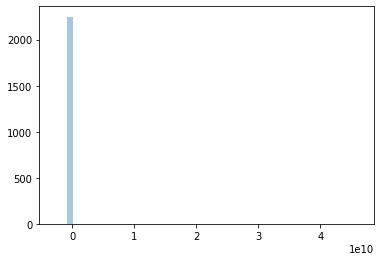

In [74]:
sns.distplot(ism_cis, kde=False)

In [77]:
output_dir = os.path.join(data_dir, 'res')
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'GATA_TAL1_true_ces_no_noise.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(ism_cis):
        f.write(f'{i}, {ci}\n')

../dat/sim/res


In [ ]:
output_dir = os.path.join(data_dir, 'res')
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'GATA_TAL1_true_ces_no_conf.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(ism_cis_no_conf):
        f.write(f'{i}, {ci}\n')

In [ ]:
output_dir = os.path.join(data_dir, 'res')
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'GATA_TAL1_true_ces_wald.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(wald_results):
        f.write(f'{i}, {ci}\n')